In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
import itertools
from pylab import rcParams
import statsmodels.api as sm
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance, plot_tree

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('PJMW_MW_Hourly.xlsx',header=0,parse_dates=True)
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077
1,2002-12-31 02:00:00,4939
2,2002-12-31 03:00:00,4885
3,2002-12-31 04:00:00,4857
4,2002-12-31 05:00:00,4930


In [3]:
df.set_index('Datetime', inplace=True)

In [4]:
#Finding outliers

def find_outliers_IQR(df):
    
    Q1 = df.quantile(0.25)

    Q3 = df.quantile(0.75)
    
    IQR = Q3 - Q1
    
    outliers= df[((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    
    return outliers

outliers = find_outliers_IQR(df['PJMW_MW'])

In [5]:
#Define the percentile limits for winsorization 

pct_lower = 0.01
pct_upper = 0.95

df['PJMW_MW'] = np.clip(df['PJMW_MW'],
                df['PJMW_MW'].quantile(pct_lower),
                df['PJMW_MW'].quantile(pct_upper))

In [6]:
df['PJMW_MW']

Datetime
2002-12-31 01:00:00    5077.0
2002-12-31 02:00:00    4939.0
2002-12-31 03:00:00    4885.0
2002-12-31 04:00:00    4857.0
2002-12-31 05:00:00    4930.0
                        ...  
2018-01-01 20:00:00    7330.0
2018-01-01 21:00:00    7330.0
2018-01-01 22:00:00    7330.0
2018-01-01 23:00:00    7330.0
2018-01-02 00:00:00    7330.0
Name: PJMW_MW, Length: 143206, dtype: float64

In [7]:
df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Month'] = df.index.month
df['Year'] = df.index.year
df

,PJMW_MW,Hour,Day,Month,Year
Datetime,,,,,
2002-12-31 01:00:00,5077.0,1,31,12,2002
2002-12-31 02:00:00,4939.0,2,31,12,2002
2002-12-31 03:00:00,4885.0,3,31,12,2002
2002-12-31 04:00:00,4857.0,4,31,12,2002
2002-12-31 05:00:00,4930.0,5,31,12,2002
...,...,...,...,...,...
2018-01-01 20:00:00,7330.0,20,1,1,2018
2018-01-01 21:00:00,7330.0,21,1,1,2018
2018-01-01 22:00:00,7330.0,22,1,1,2018


df.dtypes

In [8]:
df.head()

,PJMW_MW,Hour,Day,Month,Year
Datetime,,,,,
2002-12-31 01:00:00,5077.0,1,31,12,2002
2002-12-31 02:00:00,4939.0,2,31,12,2002
2002-12-31 03:00:00,4885.0,3,31,12,2002
2002-12-31 04:00:00,4857.0,4,31,12,2002
2002-12-31 05:00:00,4930.0,5,31,12,2002


In [9]:
#Train-Test split

train=df.loc[df.Year < 2018]
test = df.loc[df.Year >= 2018]

In [10]:
xtrain = train[['Hour','Day','Month','Year']]
xtest = test[['Hour','Day','Month','Year']]
ytrain = train[['PJMW_MW']]
ytest = test[['PJMW_MW']]

In [11]:
xtrain

,Hour,Day,Month,Year
Datetime,,,,
2002-12-31 01:00:00,1,31,12,2002
2002-12-31 02:00:00,2,31,12,2002
2002-12-31 03:00:00,3,31,12,2002
2002-12-31 04:00:00,4,31,12,2002
2002-12-31 05:00:00,5,31,12,2002
...,...,...,...,...
2017-01-01 20:00:00,20,1,1,2017
2017-01-01 21:00:00,21,1,1,2017
2017-01-01 22:00:00,22,1,1,2017


In [12]:
ytrain

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0
...,...
2017-01-01 20:00:00,5690.0
2017-01-01 21:00:00,5668.0
2017-01-01 22:00:00,5543.0


In [13]:
xtrain.values

array([[   1,   31,   12, 2002],
       [   2,   31,   12, 2002],
       [   3,   31,   12, 2002],
       ...,
       [  22,    1,    1, 2017],
       [  23,    1,    1, 2017],
       [   0,    2,    1, 2017]], dtype=int64)

In [14]:
xg_model = XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.03,
                        max_depth= 5, min_child_weight= 4,
                        n_estimators= 500, nthread= 4, objective= 'reg:linear', 
                        silent= 1, subsample= 0.7)
xg_model.fit(xtrain.values, ytrain.values,
       eval_set = [(xtrain.values, ytrain.values), (xtest.values, ytest.values)],
        early_stopping_rounds=50,
       verbose=100)

[12:02:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:02:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-rmse:5484.81404	validation_1-rmse:5700.93748
[100]	validation_0-rmse:647.75906	validation_1-rmse:836.88693
[200]	validation_0-rmse:538.31399	validation_1-rmse:690.02797
[300]	validation_0-rmse:514.87829	validation_1-rmse:678.17850
[338]	validation_0-rmse:510.21522	validation_1-rmse:679.04457


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, nthread=4, num_parallel_tree=None,
             objective='reg:linear', ...)

In [15]:
ypred= xg_model.predict(xtest.values)
ypred

array([5040.51  , 4864.7183, 4649.749 , ..., 5628.968 , 5270.449 ,
       5359.6367], dtype=float32)

In [16]:
xtest

,Hour,Day,Month,Year
Datetime,,,,
2018-01-01 00:00:00,0,1,1,2018
2018-08-02 01:00:00,1,2,8,2018
2018-08-02 02:00:00,2,2,8,2018
2018-08-02 03:00:00,3,2,8,2018
2018-08-02 04:00:00,4,2,8,2018
...,...,...,...,...
2018-01-01 20:00:00,20,1,1,2018
2018-01-01 21:00:00,21,1,1,2018
2018-01-01 22:00:00,22,1,1,2018


In [17]:
rmse= np.sqrt(mean_squared_error(ytest.values, ypred))
rmse

676.6961524013702

In [18]:
ypred

array([5040.51  , 4864.7183, 4649.749 , ..., 5628.968 , 5270.449 ,
       5359.6367], dtype=float32)

In [19]:
from sklearn.metrics import r2_score
score = r2_score(ytest, ypred)
score

0.44379209053708124

In [20]:
from datetime import datetime
datetime_str = '08/03/18 00:00:00'
datetime_object = datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S')
print(datetime_object)

2018-08-03 00:00:00


In [21]:
index_of_forecast = pd.date_range(datetime_object + pd.DateOffset(days=1), periods = 30*24, freq='H')
index_of_forecast

DatetimeIndex(['2018-08-04 00:00:00', '2018-08-04 01:00:00',
               '2018-08-04 02:00:00', '2018-08-04 03:00:00',
               '2018-08-04 04:00:00', '2018-08-04 05:00:00',
               '2018-08-04 06:00:00', '2018-08-04 07:00:00',
               '2018-08-04 08:00:00', '2018-08-04 09:00:00',
               ...
               '2018-09-02 14:00:00', '2018-09-02 15:00:00',
               '2018-09-02 16:00:00', '2018-09-02 17:00:00',
               '2018-09-02 18:00:00', '2018-09-02 19:00:00',
               '2018-09-02 20:00:00', '2018-09-02 21:00:00',
               '2018-09-02 22:00:00', '2018-09-02 23:00:00'],
              dtype='datetime64[ns]', length=720, freq='H')

In [22]:
forecast_data = pd.DataFrame(index=index_of_forecast)
forecast_data['hour'] = forecast_data.index.hour
forecast_data['month'] =forecast_data.index.month
forecast_data['year'] = forecast_data.index.year
forecast_data['Day'] = forecast_data.index.day
forecast_data

,hour,month,year,Day
2018-08-04 00:00:00,0,8,2018,4
2018-08-04 01:00:00,1,8,2018,4
2018-08-04 02:00:00,2,8,2018,4
2018-08-04 03:00:00,3,8,2018,4
2018-08-04 04:00:00,4,8,2018,4
...,...,...,...,...
2018-09-02 19:00:00,19,9,2018,2
2018-09-02 20:00:00,20,9,2018,2
2018-09-02 21:00:00,21,9,2018,2
2018-09-02 22:00:00,22,9,2018,2


In [23]:
forecast = xg_model.predict(forecast_data.values)
forecast = pd.DataFrame(forecast, columns=['Forecast'], index=forecast_data.index)
forecast

,Forecast
2018-08-04 00:00:00,5953.647949
2018-08-04 01:00:00,5667.993164
2018-08-04 02:00:00,5562.020508
2018-08-04 03:00:00,5515.159180
2018-08-04 04:00:00,5508.535156
...,...
2018-09-02 19:00:00,6811.372070
2018-09-02 20:00:00,6810.887695
2018-09-02 21:00:00,6790.574707
2018-09-02 22:00:00,6663.119141


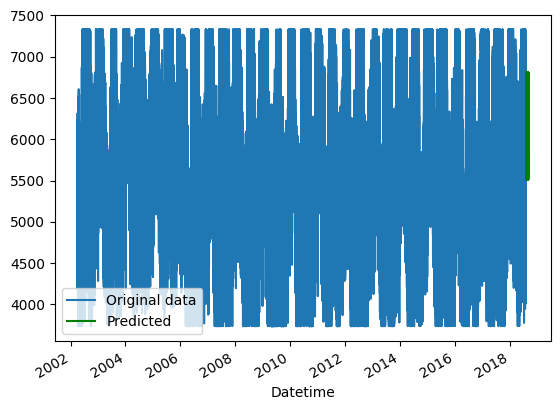

In [24]:
fig, ax = plt.subplots()
plt.rcParams['figure.figsize']=(16,8)
plt.rcParams['figure.dpi']= 300
df['PJMW_MW'].plot(ax=ax, label='Original data')
#final_pred.plot(ax=ax, label='Predicted')
forecast.plot(ax=ax, label='Forecast', color='green')
plt.legend(['Original data', 'Predicted', 'Forecast'])

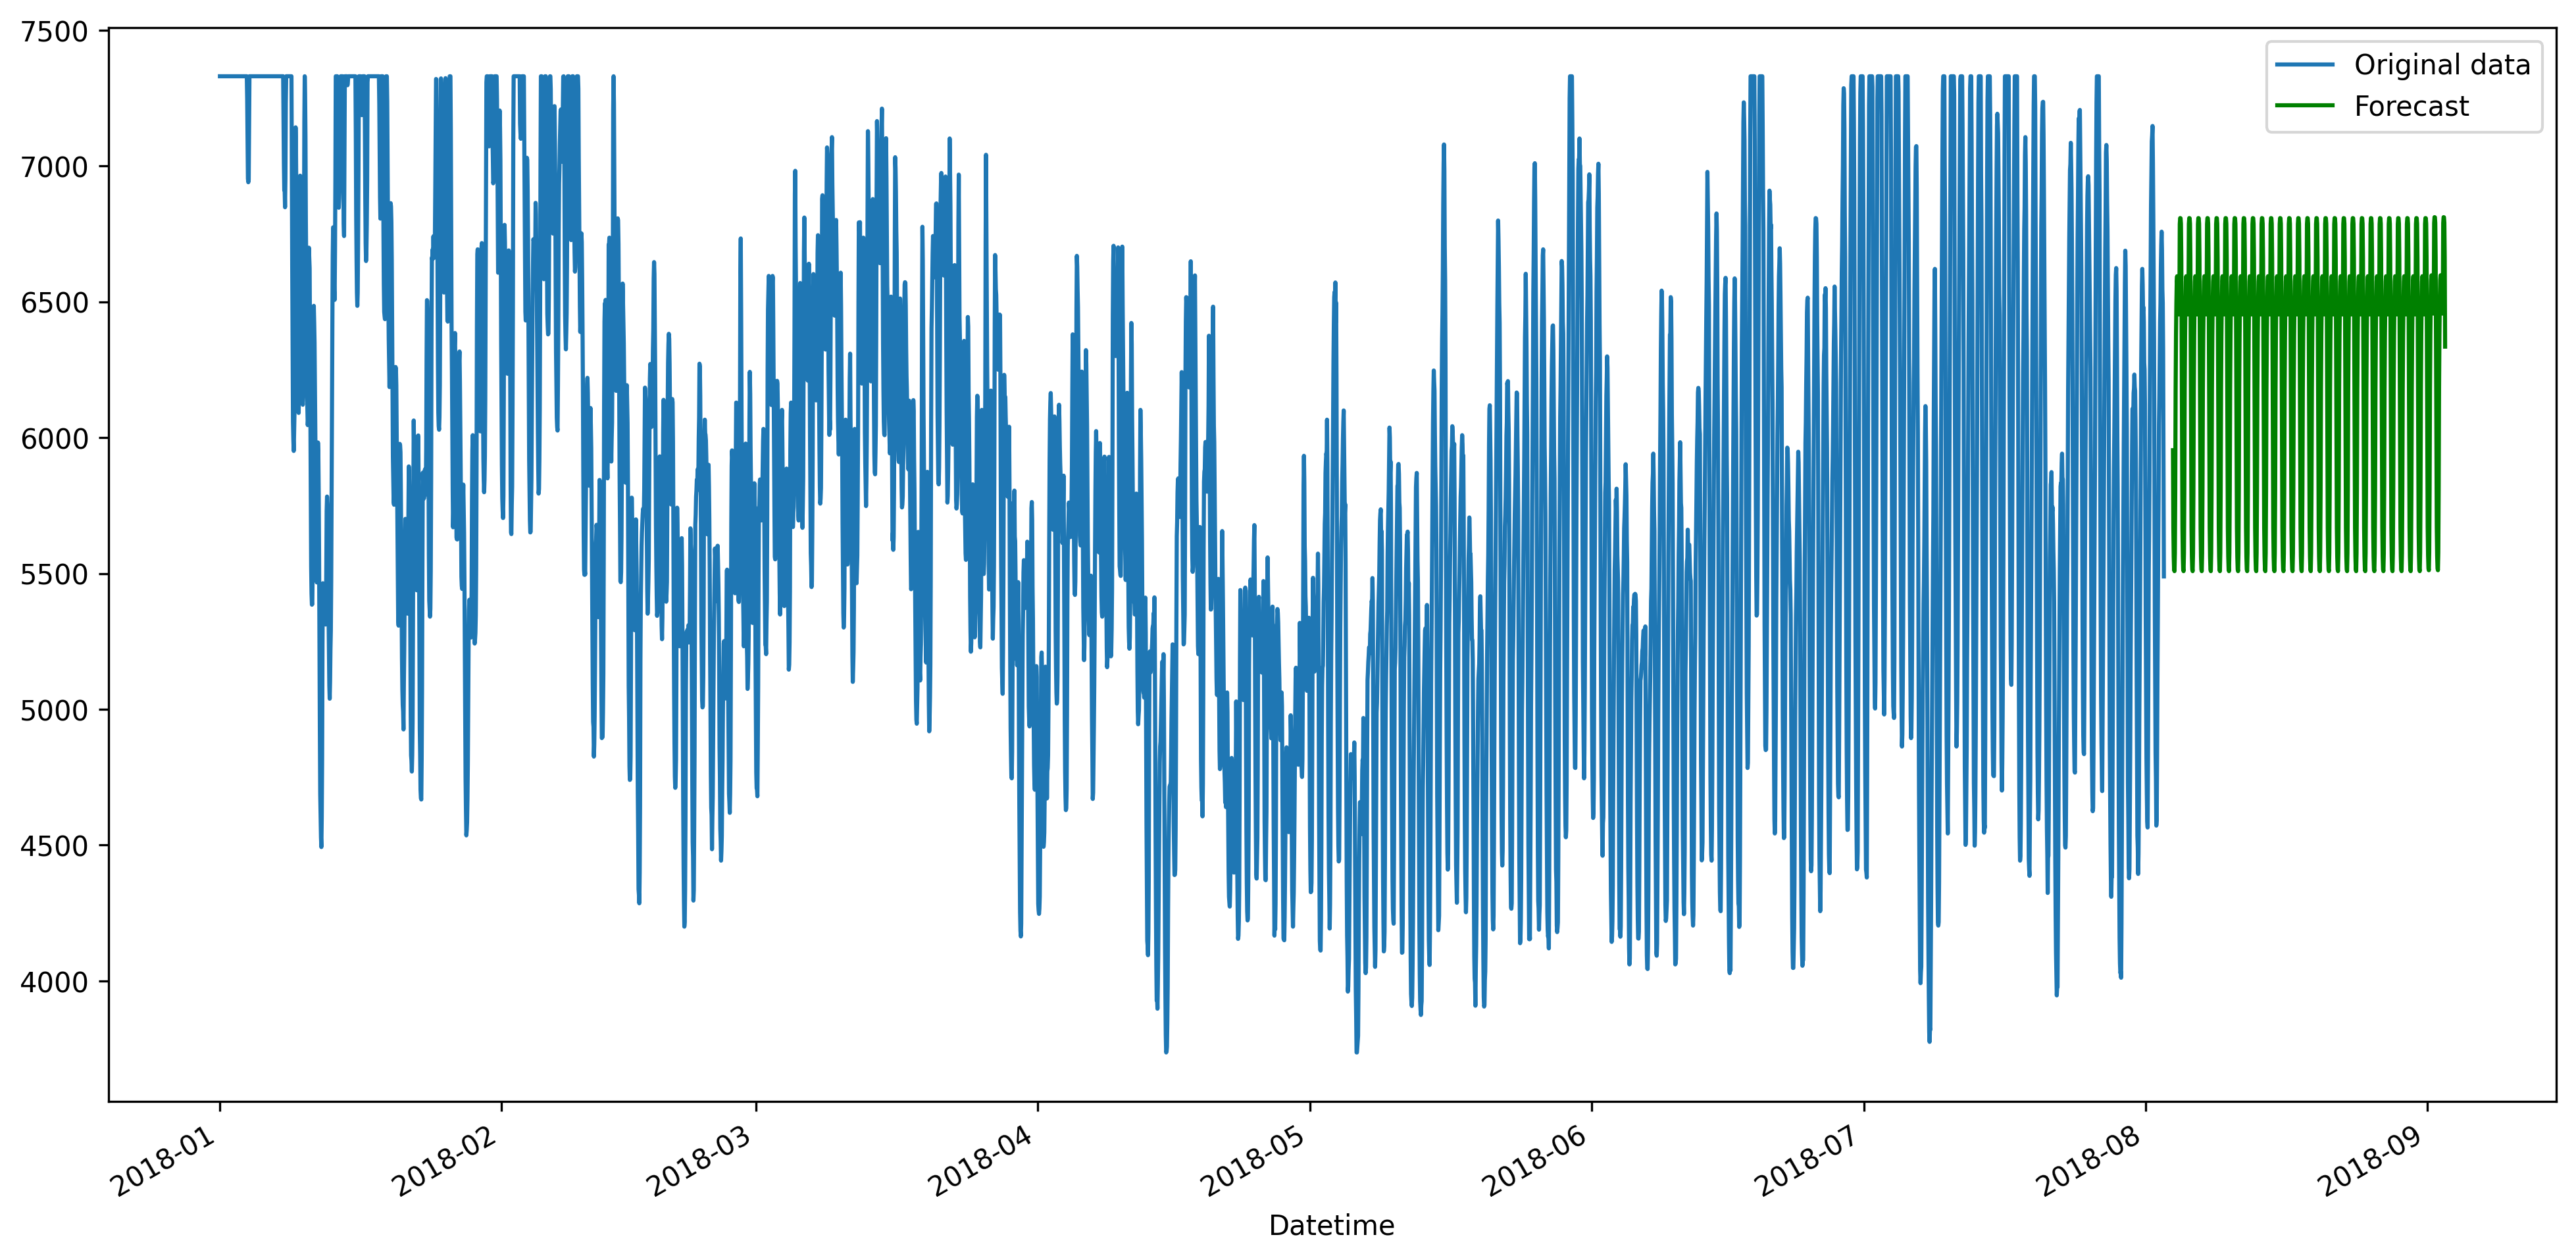

In [25]:
fig, ax = plt.subplots()
ytest['PJMW_MW'].plot(ax=ax, label='Original data')
forecast.plot(ax=ax, label='Forecast', color='green')
plt.legend(['Original data', 'Forecast'])

In [26]:
import pickle

pickle.dump(xg_model, open('xg_model_values.pkl', 'wb'))

In [27]:
xg_model.predict([[8,1,2018,4]])

array([6048.417], dtype=float32)

In [28]:
model = open('xg_model_values.pkl','rb')
xg_model = pickle.load(model)

In [29]:
xg_model.predict([[8,1,2018,4]])

array([6048.417], dtype=float32)